In [1]:
import regex
import pandas as pd
import numpy as np
import emoji
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
def date_time(s):
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)? -'
    result = regex.match(pattern, s)
    if result:
        return True
    return False

def find_author(s):
    s = s.split(":")
    if len(s)==2:
        return True
    else:
        return False

def getDatapoint(line):
    splitline = line.split(' - ')
    dateTime = splitline[0]
    date, time = dateTime.split(", ")
    message = " ".join(splitline[1:])
    if find_author(message):
        splitmessage = message.split(": ")
        author = splitmessage[0]
        message = " ".join(splitmessage[1:])
    else:
        author= None
    return date, time, author, message
def split_count(text):
    emoji_list = []
    data = regex.findall(r'\X',text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)
    return emoji_list

In [3]:
data = []
conversation = 'MAVA-WhatsApp.txt'
with open(conversation, encoding="utf-8") as fp:
    fp.readline()
    messageBuffer = []
    date, time, author = None, None, None
    while True:
        line = fp.readline()
        if not line:
            break
        line = line.strip()
        if date_time(line):
            if len(messageBuffer) > 0:
                data.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDatapoint(line)
            messageBuffer.append(message)
        else:
            messageBuffer.append(line)

In [4]:
df = pd.DataFrame(data, columns=["Date", 'Time', 'Author', 'Message'])
df['Date'] = pd.to_datetime(df['Date'])
print("Particiapnts:",df.Author.unique())
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: regex.findall(URLPATTERN, x)).str.len()
links = np.sum(df.urlcount)
print("Total Number of messages:",df.shape[0])
print("Total number of media messages:",df[df["Message"]=='<Media omitted>'].shape[0])
print("Total number of links shared:",links)

Particiapnts: [None 'Papa' 'Adya' 'Amogh Garg' 'Mummy']
Total Number of messages: 1239
Total number of media messages: 543
Total number of links shared: 45


Stats of Papa -
Messages Sent: 274
Average Words per message: 9.014598540145986
Media Messages Sent: 375
Links Sent: 0


Stats of Adya -
Messages Sent: 75
Average Words per message: 4.36
Media Messages Sent: 17
Links Sent: 0


Stats of Amogh Garg -
Messages Sent: 150
Average Words per message: 4.073333333333333
Media Messages Sent: 64
Links Sent: 1


Stats of Mummy -
Messages Sent: 127
Average Words per message: 5.488188976377953
Media Messages Sent: 87
Links Sent: 0


[649, 92, 214, 214]


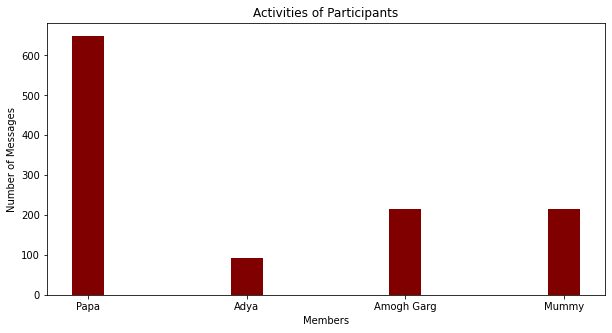

In [9]:
media_messages_df = df[df['Message'] == '<Media omitted>']
messages_df = df.drop(media_messages_df.index)
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))
messages_df["MessageCount"]=1

l = df.Author.unique()
bar_graph=[]
for i in range(1,len(l)):
    # Filtering out messages of particular user
    req_df= messages_df[messages_df["Author"] == l[i]]
    # req_df will contain messages of only one particular user
    print(f'Stats of {l[i]} -')
    # shape will print number of rows which indirectly means the number of messages
    print('Messages Sent:', req_df.shape[0])
    #Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
    words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]
    print('Average Words per message:', words_per_message)
    #media conists of media messages
    media = media_messages_df[media_messages_df['Author'] == l[i]].shape[0]
    print('Media Messages Sent:', media)
    #links consist of total links
    links = sum(req_df["urlcount"])   
    print('Links Sent:', links)
    print('\n')
    bar_graph.append(len(req_df)+media)
print(bar_graph)
fig = plt.figure(figsize = (10, 5))
plt.bar(l[1:],bar_graph,color ='maroon',width =0.2)
plt.xlabel("Members")
plt.ylabel("Number of Messages")
plt.title("Activities of Participants")
plt.show()
    

There are 31159 words in all the messages.


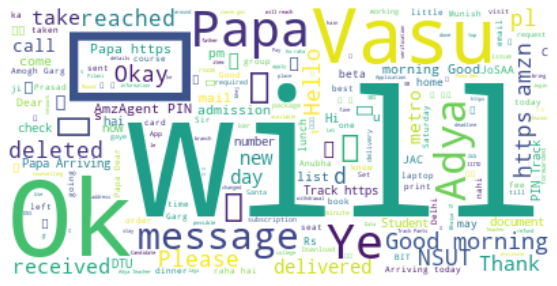

In [7]:
text = " ".join(review for review in messages_df.Message)
print ("There are {} words in all the messages.".format(len(text)))
stopwords = set(STOPWORDS)
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
# Display the generated image:
# the matplotlib way:
plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()